# Calculating integrals in SQL

In previous chapters we saw how we could implement an `eval` function in SQL,
and use that to query useless neurons. In this chapter, we'll look at another
practical example: calculating the integral of a function represented by a
neural network.

The paper shows how we can calculate integrals for any neural network with one
output neuron. In this notebook, we'll focus on the simplest case: a network
with one input and one hidden layer. This allows us to calculate integrals for
all continuous piecewise linear functions $\mathbb{R} \rightarrow \mathbb{R}$.

## Creating a simple neural network

First, some preliminary imports.

In [8]:
import torch
import torch.onnx
import numpy as np
import matplotlib.pyplot as plt
import utils.duckdb as db
import utils.nn as nn

# Make things reproducible.
torch.manual_seed(110033)

> The utility code can be downloaded from [nn.py](utils/nn.py).

Let's create the custom function $f$ that we can train our neural network on:

- $y = 0$ when $x < 0$
- $y = x$ when $x >= 0$ and $x < 5$
- $y = 10 - x$ when $x >= 5$ and $x <10$
- $y = 0$ when $x > 10$

This is a piecewise linear function with an integral of 5.

In [9]:
def f(x):
    if x < 0:
        return 0
    elif 0 <= x < 5:
        return x
    elif 5 <= x < 10:
        return 10-x
    else:
        return 0

x_train = np.linspace(-5, 15, 1000)
y_train = np.array([f(x) for x in x_train])

Let's visualize the function.

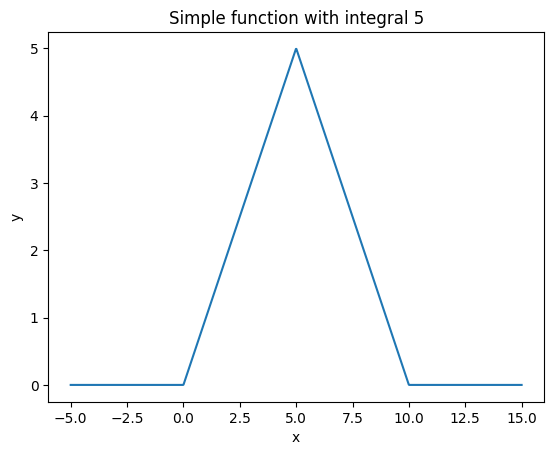

In [10]:
fig, ax = plt.subplots()
ax.plot(x_train, y_train)

ax.set(xlabel='x', ylabel='y',
       title='Simple function with integral 5')
plt.show()

Now we'll create a neural network that can predict this function using PyTorch.
We use 3 hidden neurons, one for each breakpoint in the function.

In [11]:
model = nn.ReLUFNN(input_size=1, output_size=1, hidden_size=3, num_hidden_layers=1)
nn.train(model, x_train, y_train, save_path="models/integral.pt")

Let's plot how the neural network approximates our function:

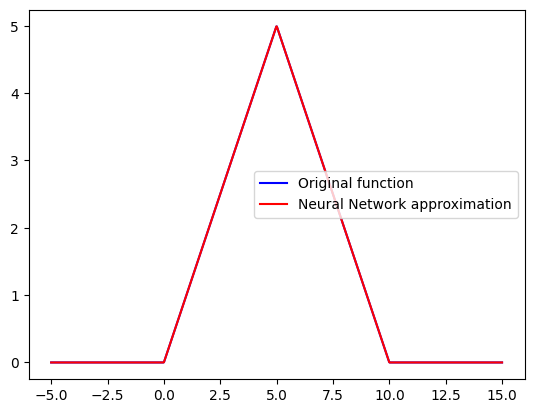

In [12]:
model.eval()
with torch.no_grad():
    predicted = model(torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)).detach().numpy()

plt.plot(x_train, y_train, 'b', label='Original function')
plt.plot(x_train, predicted, 'r', label='Neural Network approximation')
plt.legend()
plt.show()

The neural network appears to be a good approximation of the original function.
Next, we'll use our [utility module](./utils/duckdb.py) to save the model to a
database and display its contents.

In [13]:
db.load_pytorch_model_into_db(model)
db.print_db_contents()

┌────────────────────────────┬───────────────┐
│            name            │     bias      │
│          varchar           │     float     │
├────────────────────────────┼───────────────┤
│ input.0                    │           0.0 │
│ linear_relu_stack.0.bias.0 │     3.4990036 │
│ linear_relu_stack.0.bias.1 │     3.4577463 │
│ linear_relu_stack.0.bias.2 │ -1.605861e-05 │
│ linear_relu_stack.2.bias.0 │  2.441732e-05 │
└────────────────────────────┴───────────────┘

┌────────────────────────────┬────────────────────────────┬─────────────┐
│            src             │            dst             │   weight    │
│          varchar           │          varchar           │    float    │
├────────────────────────────┼────────────────────────────┼─────────────┤
│ input.0                    │ linear_relu_stack.0.bias.0 │  -0.3498958 │
│ input.0                    │ linear_relu_stack.0.bias.1 │ -0.69156605 │
│ input.0                    │ linear_relu_stack.0.bias.2 │  -1.4708188 │
│ linear_relu_stack.0.bias.0 │ linear_relu_stack.2.bias.0 │   2.8578548 │
│ linear_relu_stack.0.bias.1 │ linear_relu_stack.2.bias.0 │  -2.8919613 │
│ linear_relu_stack.0.bias.2 │ linear_relu_stack.2.bias.0 │  0.67988795 │
└────────────────────────────┴────────────────────────────┴─────────────┘

## Calculating the integral using SQL

We already analyzed the `eval` function in a [previous
notebook](./1.4%20Eval%20-%20recursive.ipynb) and its following chapters.
Calculating the integral of a function represented by a neural network also
relies on the `eval` function. In essence, we first locate the breakpoints of
the function - represented by one (or more) hidden neurons. By running `eval` on
these breakpoints we get the respective y-values, which we can use to calculate
the integral.

For a neuron in the hidden layer, we can calculate the x-coordinate of the
breakpoint it represents as follows:

$$
break_x(u) := \frac{-b(u)}{w(in_1,u)}
$$

The y-value is then:

$$
break_y(u) := eval_1(break_x(u))
$$

We also need an ordering of the neurons based on the successive breakpoints. For
this we use the formula $succ(u_1, u_2)$.

The area of the piece of the function between $u_1$ and $u_2$ becomes:

$$
area(u_1, u_2) = \frac{1}{2}(break_y(u_1) + break_y(u_2))(break_x(u_2) - break_x(u_1))
$$

We sum these to get the integral, dividing by the number of (possible) duplicates.

The query that implements this looks as follows:

```sql
WITH input_node AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT dst FROM edge)
),
output_node AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT src FROM edge)
),
hidden_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (
        SELECT * FROM input_node
        UNION
        SELECT * FROM output_node
    )
),
break_x AS (
    SELECT
        n.id,
        (-n.bias) / e.weight AS break_x, -- -b(u) / w(in1, u)
        ROW_NUMBER() OVER (ORDER BY (-n.bias) / e.weight) AS row_number
    FROM node n
    JOIN edge e ON e.dst = n.id
    JOIN input_node i ON e.src = i.id
    JOIN hidden_nodes h ON h.id = n.id
    WHERE e.weight <> 0
    ORDER BY break_x
),
-- The possible inputs we'll evaluate on for this query.
vals AS (
    SELECT break_x AS val FROM break_x
),
weight_times_input_value AS (
    SELECT
        SUM(e.weight * v.val) AS weight_times_value,
        e.dst AS id,
        v.val AS input_value
    FROM edge e
    JOIN input_node i ON i.id = e.src
    CROSS JOIN vals v
    GROUP BY e.dst, v.val
),
t1 AS (
    SELECT
        GREATEST(weight_times_value + n.bias, 0) AS t1_value,
        input_value,
        n.id
    FROM node n
    JOIN weight_times_input_value i ON i.id = n.id
),
t1_sums AS (
    SELECT
        SUM(
            e.weight *
            t1.t1_value
        ) AS sum,
        t1.input_value,
        e.dst
    FROM edge e
    JOIN t1 ON t1.id = e.src
    GROUP BY t1.input_value, e.dst
),
eval AS (
    SELECT
        t.input_value,
        n.bias + t.sum AS final_output
    FROM node n
    JOIN t1_sums t ON t.dst = n.id
    JOIN output_node o ON o.id = n.id
),
breaks AS (
    SELECT
        u1.break_x AS u1_break_x,
        u2.break_x AS u2_break_x,
        e1.final_output AS u1_break_y,
        e2.final_output AS u2_break_y
    FROM break_x u1
    JOIN break_x u2 ON u1.row_number = u2.row_number - 1
    JOIN eval e1 ON u1.break_x = e1.input_value
    JOIN eval e2 ON u2.break_x = e2.input_value
),
areas AS (
    SELECT
        0.5 * (u1_break_y + u2_break_y) * (u2_break_x - u1_break_x) AS area
    FROM breaks
)

SELECT SUM(area) AS integral FROM areas
```

This query can be found in [integral.sql](./queries/integral.sql) as well. Let's break it
down.

`input_node`, `output_node`, and `hidden_nodes` are simple CTEs that select
nodes of a specific layer. Remember, in our case we only have one input node,
one output node, and one hidden layer.

```sql
break_x AS (
    SELECT
        n.id,
        (-n.bias) / e.weight AS break_x, -- -b(u) / w(in1, u)
        ROW_NUMBER() OVER (ORDER BY (-n.bias) / e.weight) AS row_number
    FROM node n
    JOIN edge e ON e.dst = n.id
    JOIN input_node i ON e.src = i.id
    JOIN hidden_nodes h ON h.id = n.id
    WHERE e.weight <> 0
    ORDER BY break_x
)
```

This section yields all breakpoints of the function, as defined by $break_x(u)$.
We also use the `ROW_NUMBER` trick to give each breakpoint a numeric index based
on its x-value. This way we can sort on this later on.

```sql
breaks AS (
    SELECT
        u1.break_x AS u1_break_x,
        u2.break_x AS u2_break_x,
        e1.final_output AS u1_break_y,
        e2.final_output AS u2_break_y
    FROM break_x u1
    JOIN break_x u2 ON u1.row_number = u2.row_number - 1
    JOIN eval e1 ON u1.break_x = e1.input_value
    JOIN eval e2 ON u2.break_x = e2.input_value
),
areas AS (
    SELECT
        0.5 * (u1_break_y + u2_break_y) * (u2_break_x - u1_break_x) AS area
    FROM breaks
)
```

The `breaks` CTE looks at every pair of breakpoints and calculates their
$break_y$ values. The `areas` CTE plugs these values in the formula that
calculates the integral for one piece of a piecewise linear function.

```sql
SELECT SUM(area) AS integral FROM areas
```

In our final query, we simply sum the integral of each piece to get the integral
of the entire function.

We don't explain any other CTEs, such as `t1` or `t1_sums`, as these are used to
implement `eval` in SQL, which is discussed in a [previous
notebook](./1.1%20Eval%20-%20basic%20eval.ipynb).

Running our integral query yields the following result:

In [14]:
with open('queries/integral.sql', 'r') as query_file:
    query = query_file.read()

db.con.sql(query)

┌────────────────────┐
│      integral      │
│       double       │
├────────────────────┤
│ 25.000555736314418 │
└────────────────────┘

As we can see, this is equal to the expected integral of 25, barring some
rounding errors.

## Conclusion

We constructed a proof-of-concept SQL query that is able to calculate the
integral of a function represented by a neural network.

In later work, we can expand on this to handle larger neural networks as well.